# Sentinel-5P irradiance measurement animation

As part of the commissioning phase of the TROPOMI instrument on board of the ESA's Sentinel-5P spacecraft, a dedicated radiometric measurement was put in place to estimate radiometric errors in Level 1B products based on S5P early in-flight calibration measurements.  

Simulations of atmospheric transmission spectra showed that the atmosphere is opaque at tangent altitudes below 15-10km, near the O<sub>2</sub> A Band at 761 nm.  
Measurements in this range, taken in a so-called solar occultation geometry, could potentially be used to detect residual out-of-band stray light effects.

In this post, we are going to show how to use Matplotlib to display an animated plot of the solar irradiance spectra detected during this dedicated solar calibration measurement, as a function of time – which roughly translates in decreasing limb tangent heights — and observe the strong O<sub>2</sub> A Band absorption features occurring around 761 nm.

## Loading the data

Let’s import our favourite libraries and load the data from our input product.

In [1]:
import dateutil.parser
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from datetime import datetime, timedelta
from os.path import join

Our data are contained in a Sentinel-5P L1B product, containing both measurements and instrument data in a NetCDF4 file.
Let’s open it and extract the variable we are interested in:
* `irradiance`, that is the measured spectral irradiance for each spectral pixel and each associated spectral channel, across all scanlines (which is our time dimension). Irradiance is a measurement of solar power and is defined as the rate at which solar energy falls onto a surface.
* `calibrated_wavelength`, a calibrated set of wavelengths derived from the comparison between the obtained irradiance measurement and a reference solar spectrum, which provides a per pixel best estimate for the wavelength actually measured by each individual spectral channel.

In [2]:
input_dir = '/Users/stefano/src/s5p/products'
output_dir = '/Users/stefano/src/s5p/plots' # to store our animations
input_product = 'S5P_OFFL_L1B_CA_UVN_20171119T055356_20171119T073526_00523_01_001200_20171119T123144.nc'
l1b = nc.Dataset(join(input_dir, input_product))

measurements = l1b.groups['BAND6_IRRADIANCE'].groups['SOLAR_IRRADIANCE_SPECIAL_MODE_0266']
observations = measurements.groups['OBSERVATIONS']
instrument = measurements.groups['INSTRUMENT']

irradiance = observations.variables['irradiance']
calibrated_wavelength = instrument.variables['calibrated_wavelength']

/Users/stefano/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: WARNING: unsupported Compound type, skipping...
  after removing the cwd from sys.path.


The scanline relative timestamps can be derived by adding the `delta_time` values, expressed as milliseconds from the reference time, to a `time_reference` value.  
We are going to make use of the `dateutil` module to parse the `time_reference` attribute, which is an UTC time specified as an ISO 8601 date, and then build an array of relative time stamps that can be indexed by our scanlines.

In [3]:
time_reference = dateutil.parser.parse(l1b.time_reference)

relative_timestamps =\
    np.array([time_reference+\
             timedelta(milliseconds=int(observations.variables['delta_time'][0, scanline])) 
             for scanline in range(len(observations.variables['scanline']))])
    
print("Reference time: {}".format(time_reference))

Reference time: 2017-11-19 00:00:00+00:00


## Making sense of the data

Let's have a closer look at our `irradiance` variable:

In [4]:
print(irradiance)

<class 'netCDF4._netCDF4.Variable'>
float32 irradiance(time, scanline, pixel, spectral_channel)
    ancilary_vars: irradiance_noise irradiance_error quality_level spectral_channel_quality
    _FillValue: 9.96921e+36
    units: mol.m-2.nm-1.s-1
    long_name: spectral photon irradiance
path = /BAND6_IRRADIANCE/SOLAR_IRRADIANCE_SPECIAL_MODE_0266/OBSERVATIONS
unlimited dimensions: 
current shape = (1, 2772, 504, 520)
filling on


Which, speaking human, tells us that for each of the 2772 scanlines, there are 504 pixels and 520 associated spectral channels. Each pixel in this tridimensional grid specifies an irradiance measurement represented as a float value.

We want to "slice" the measurements around the area of interest: O<sub>2</sub> A band at 761 nm, for example in the 756:772 nm range.  

Let's consider a pixel – our reference pixel for the remainder of this post – in the centre of the swath, and its associated spectral channels, and let's use NumPy's `where` function to retrieve the spectral channel range enclosing the wavelengths we are interested in.

In [5]:
PIXEL = 252
WL_MIN, WL_MAX = (756, 772)
sc_slice = np.where((calibrated_wavelength[0,PIXEL,:] > WL_MIN) & 
                    (calibrated_wavelength[0,PIXEL,:] < WL_MAX))
sc_min, sc_max = (np.min(sc_slice), np.max(sc_slice))
print("Spectral channel range: ({}, {})".format(sc_min, sc_max))

Spectral channel range: (254, 384)


##  Plotting the data

Now that we know at which spectral channels we need to look at, let's have a quick look at the irradiance level evolution across all scanlines, that is with respect to the spacecraft relative position to the sun.  
For that, we are going to make use of Matplotlib's `pcolormesh` function.

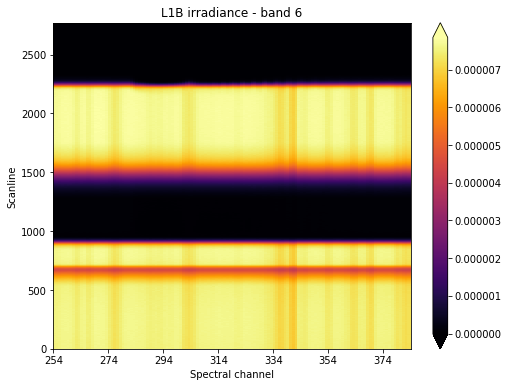

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.pcolormesh(irradiance[0, :, PIXEL, sc_min:sc_max], cmap=plt.get_cmap('inferno'))
ax.set_xticklabels(range(sc_min, sc_max, 20))
ax.set_xlabel('Spectral channel')
ax.set_ylabel('Scanline')
ax.set_title("L1B irradiance - band 6")
cbar = fig.colorbar(cax, ax=ax, extend='both')
plt.show()

We want to focus our attention at what's happening around scanline 2250, which seems to be around the time where the sun "sets" from the point of view of our instrument's line of sight.

We could then slice our original irradiance along the scanline and spectral channel axes. At the same time, we could improve our signal to noise ratio, by averaging measurements around our reference pixel. This will reduce our total number of dimensions by one.

In [7]:
SCANLINE_MIN, SCANLINE_MAX = (2200, 2340)
NUM_PIXEL_AVG = 20 # number of adjacent pixels to average, for noise reduction

irradiance = irradiance[0, 
                        SCANLINE_MIN:SCANLINE_MAX, 
                        PIXEL-NUM_PIXEL_AVG:PIXEL+NUM_PIXEL_AVG, 
                        sc_min:sc_max].mean(axis=1)

We could also slice our `calibrated_wavelength` array around our reference pixel.

In [8]:
calibrated_wavelength = calibrated_wavelength[0,PIXEL,:]

Let's now plot our averaged irradiance for a subset of scanlines:

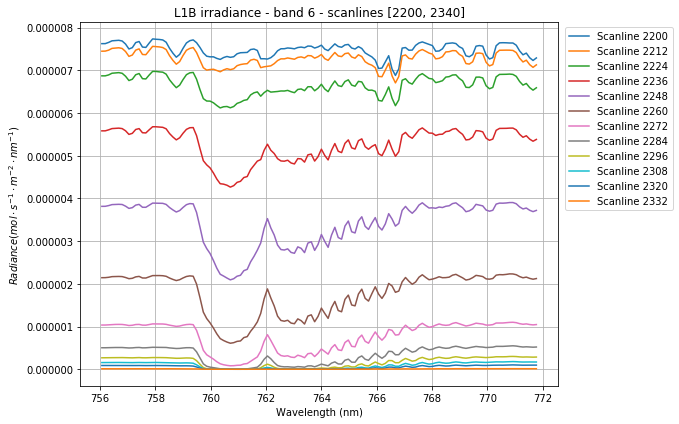

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
STEP = 12

for sl in range(0, SCANLINE_MAX-SCANLINE_MIN, STEP):
    lines = ax.plot(calibrated_wavelength[sc_min:sc_max], 
                    irradiance[sl,:], 
                    label="Scanline {}".format(SCANLINE_MIN+sl))

ax.grid(True)
ax.legend(bbox_to_anchor=[1.25, 1], loc='upper right')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$Radiance (mol \cdot s^{−1} \cdot m^{−2} \cdot nm^{−1})$')
ax.set_title("L1B irradiance - band 6 - scanlines [{}, {}]".format(SCANLINE_MIN, 
                                                                   SCANLINE_MAX))
plt.tight_layout()
plt.show()

We can clearly notice how the irradiance gets squashed as the sun gradually drops out of sight. Also, the effect of the O<sub>2</sub> absorption is distinctly visible around 761nm.  

How cool would it be to animate this sequence?

## Animating the data

It turns out that we can easily setup animations in Matplotlib: we just need to set up our plot first, and then define a function specifying the frame to be plotted at the i<sub>th</sub> step in the animation.

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
line, = ax.plot([], [], lw=2)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$Radiance (mol \cdot s^{−1} \cdot m^{−2} \cdot nm^{−1})$')
ax.set_title("L1B irradiance - band 6 - scanlines [{}, {}]".format(SCANLINE_MIN, 
                                                                   SCANLINE_MAX))
ax.set_xlim((calibrated_wavelength[sc_min], calibrated_wavelength[sc_max]))
ax.set_ylim((irradiance.min(), irradiance.max()*1.1))
ax.grid(True)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def animate(i):
    line.set_data(calibrated_wavelength[sc_min:sc_max], irradiance[i,:])
    time_text.set_text("Scanline {}, time {}".format(i+SCANLINE_MIN, 
                                                     relative_timestamps[i+SCANLINE_MIN]))
    return (line,)        

Next, we are going to pass the just defined `animate` function to `FuncAnimation`, which is Matplotlib's function used to make an animation by repeatedly calling a function. We need to specify the number of frames and the delay between frames in milliseconds. The `blit` parameter tells the function to re-draw only the parts of the frame that have changed.

In [11]:
anim = animation.FuncAnimation(fig, animate,
                               frames=SCANLINE_MAX-SCANLINE_MIN, 
                               interval=100, blit=True)

Next, we are going to make use of IPython's inline display tools to display our animation within the Jupyter notebook.

In [12]:
HTML(anim.to_html5_video())

We can now save our animation.

In [13]:
anim.save(join(output_dir, 'irradiance_animation.mp4'))

How can we add a bit of life in our animation? What about animating a `pcolormesh` plot of the irradiance over a rolling window of a given number of scanlines? Now that would be cool!  

We are going to start by defining a few parameters defining the scope of the animation, and by retrieving our original `irradiance` variable and re-slicing it to increase the scanline range. 

In [14]:
SCANLINES_PER_FRAME = 200
SCANLINE_START = 2000
num_frames = len(observations.variables['scanline'])-SCANLINES_PER_FRAME-SCANLINE_START
irradiance = observations.variables['irradiance']
irradiance = irradiance[0, 
                        SCANLINE_START:, 
                        PIXEL-NUM_PIXEL_AVG:PIXEL+NUM_PIXEL_AVG, 
                        sc_min:sc_max].mean(axis=1)

We defined a rectangle of 200 scanlines over our irradiance `pcolormesh` plot, and we are going to "roll" it over the plot until it plunges in total darkness. 

Let's setup our plot.

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

x = np.array(calibrated_wavelength[sc_min:sc_max])
y = np.arange(SCANLINE_START, SCANLINE_START+SCANLINES_PER_FRAME)
X, Y = np.meshgrid(x, y)

cax = ax.pcolormesh(X, Y, irradiance[:SCANLINES_PER_FRAME,:], 
                    vmin=irradiance.min(), 
                    vmax=irradiance.max(),
                    cmap=plt.get_cmap('inferno'))

ax.set_title("Level 1B irradiance - Band 6 - Orbit#523")
ax.set_xlabel('Wavelength (nm)')
ax.get_yaxis().set_ticks([]) # remove y axis ticks

cbar = fig.colorbar(cax, ax=ax, extend='both')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$Radiance (mol \cdot s^{−1} \cdot m^{−2} \cdot nm^{−1})$')

# We are going to show the scanline range text in a semi-transparent white box
scanline_range_text = ax.text(0.02, 0.95, '', 
                              transform=ax.transAxes, color='black', 
                              bbox=dict(boxstyle='round, pad=0.3', 
                                        facecolor='white', alpha=0.5))

def animate(i):
    scanline_range_text.set_text("Scanlines {}-{}".format(SCANLINE_START+i, 
                                                          SCANLINE_START+SCANLINES_PER_FRAME+i))
    cax.set_array(irradiance[i:SCANLINES_PER_FRAME+i-1, :-1].flatten()) 

The magic behind the re-drawing of each frame lies in the `set_array` function, which redefines the QuadMesh data structure underlying the `pcolormesh` plot. Because of how the `pcolormesh` creates the QuadMesh (see definition [here](https://matplotlib.org/1.3.1/api/collections_api.html#matplotlib.collections.QuadMesh)), we need to subtract one from each dimension, to make dimensions fit together — this [answer](https://stackoverflow.com/questions/29009743/using-set-array-with-pyplot-pcolormesh-ruins-figure) on StackOverflow helped me a great deal in understanding why my plot looked funny in my first attempts.

Let's bring the animation to life and display it in our notebook.

In [16]:
anim = animation.FuncAnimation(
    fig, animate, interval=100, frames=350)

HTML(anim.to_html5_video())

We can now save the video and send it back home, now that's something that's going to make our parents proud!

In [17]:
anim.save(join(output_dir, 'irradiance_pcolormesh_animation.mp4'))

That's it for now! I hope you enjoyed this post, feel free to comment if you have questions or remarks.

The Jupyter notebook for this post is available on my [GitHub repository](https://github.com/stefanomattia/jupyter-notebooks/tree/master/earth-observation).